# BEAM Training and Inference Notebook

This notebook provides a pipeline for training the models used in the Building and Establishment Automated Mapper (BEAM) tool. It describes the inputs to the training functions, and the pipeline to generate predictions from trained models. This workflow was designed to work with 10cm aerial imagery from eThekwini Municipality. The Tiling_Notebook should be run first for image preprocessing.

## 1. Imports and set paths

In [ ]:
# Import packages
from fastai.vision.all import *
import numpy as np
import random
import os
import pytz
from datetime import datetime
from semtorch import get_segmentation_learner
from IPython.display import Audio, display
from sklearn.model_selection import train_test_split

from natsort import os_sorted
from os.path import join, exists
from os import listdir, makedirs, remove, stat
import glob

import rasterio
import rasterio.features
from rasterio.features import rasterize
import rasterio.plot
import sys
import cv2

import shapely.geometry
from shapely.geometry import MultiPolygon, Polygon
from shapely.ops import unary_union
import geopandas as gpd

Uncomment and run this next cell if running on Google Colab:

In [ ]:
# from google.colab import drive
# # Mount Google Drive
# drive.mount('/content/drive')


Update the path in this next code chunk to the root folder with your training images (should be the same as the root folder used in the tiling notebook).

Also define the path where you want models to be saved.

In [ ]:
# Set path of root folder that contains all required data
path = Path(f'your_path')

# Set codes (classes contained in masks)
codes = ['Background', 'Building']


Run this cell to confirm GPU access -- should return True:

In [ ]:
torch.cuda.is_available()

## 2. Define Required Functions and Set Parameters

### 2.1. Loss Functions

These are custom loss functions that can be used with the different models. However, the fastai default loss function for semantic segmentation (flattened cross-entropy) is recommended. The Dice Focal combined loss below produces inferior results in training, and the Dual Focal loss produces an output with two colour channels, making it difficult to use for generating predictions. 

In [ ]:
# Create custom loss functions for later experiments
class CombinedLoss:
    """Dice and Focal combined"""
    def __init__(self, axis=1, smooth=1., alpha=1.):
        store_attr()
        self.focal_loss = FocalLossFlat(axis=axis)
        self.dice_loss =  DiceLoss(axis, smooth)
        
    def __call__(self, pred, targ):
        return self.focal_loss(pred, targ) + self.alpha * self.dice_loss(pred, targ)
    
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)


class Dual_Focal_loss(nn.Module):
    """This loss is proposed in this paper: https://arxiv.org/abs/1909.11932
    """

    def __init__(self, ignore_lb=255, eps=1e-5, reduction='mean'):
        super(Dual_Focal_loss, self).__init__()
        self.ignore_lb = ignore_lb
        self.eps = eps
        self.reduction = reduction
        self.mse = nn.MSELoss(reduction='none')

    def forward(self, logits, label):
        ignore = label.data.cpu() == self.ignore_lb
        n_valid = (ignore == 0).sum()
        label = label.clone()
        label[ignore] = 0
        lb_one_hot = logits.data.clone().zero_().scatter_(1, label.unsqueeze(1), 1).detach()

        pred = torch.softmax(logits, dim=1)
        loss = -torch.log(self.eps + 1. - self.mse(pred, lb_one_hot)).sum(dim=1)
        loss[ignore] = 0
        if self.reduction == 'mean':
            loss = loss.sum() / n_valid
        elif self.reduction == 'sum':
            loss = loss.sum()
        elif self.reduction == 'none':
            loss = loss
        return loss

### Define Required Functions

These are helper functions that are used in the training functions that follow. They perform tasks that include gathering codes from a list of filenames, adjusting pixels in a mask, setting the batch size, creating missing folders, generating timestamps, creating notifications, and checking the balance of the dataset. The subsequent functions that follow in the code use these helper functions to define the arguments in the main training functions, which help to set the model hyperparameters for training.

In [ ]:

def n_codes(fnames, is_partial = True):
  """Gather the codes (classes contained in masks) from a list of `fnames`"""
  vals = set() # create an empty set to store unique values
  if is_partial:
    random.shuffle(fnames) # shuffle the list of filenames
    fnames = fnames[:10] # select the first 10 filenames
  for fname in fnames:
    msk = np.array(PILMask.create(fname)) # create a numpy array from the mask image
    for val in np.unique(msk): # loop through the unique values in the mask
      if val not in vals: # if the value is not already in the set of unique values
        vals.add(val) # add it to the set
  vals = list(vals) # convert the set back to a list
  p2c = dict() # create an empty dictionary to store the pixel-to-class mapping
  for i,val in enumerate(vals):
    p2c[i] = vals[i] # assign each unique value to a key in the dictionary
  return p2c

def get_msk(fn, p2c):
  """Grab a mask from a `filename` and adjust the pixels based on `p2c`"""
  path = Path('your_path') # set the path to the image and mask folders
  pix2class = n_codes(lbl_names) # get the pixel-to-class mapping
  fn = str(fn).replace('image_tiles', 'mask_tiles') # replace the image folder name with the mask folder name in the filename
  msk = np.array(PILMask.create(fn)) # create a numpy array from the mask image
  mx = np.max(msk) # get the maximum value in the mask
  for i, val in enumerate(p2c): # loop through the pixel-to-class mapping
    msk[msk==p2c[i]] = val # replace each pixel value in the mask with its corresponding class value
  return PILMask.create(msk) # create a PIL image from the adjusted mask

def get_y(o):
  return get_msk(o, p2c) # return the adjusted mask for a given filename

def batch_size(backbone, tile_size):
  """Automatically set batch size depending on image size and architecture used"""
  if '512' in tile_size:
    batch_size_dict = {'resnet152': 2, 'resnet101': 2, 'resnet50': 2,
                       'resnet34': 11, 'resnet18': 10, 'vgg16_bn': 2,
                       'hrnet_w18': 32, 'hrnet_w30': 32, 'hrnet_w32': 32,
                       'hrnet_w48': 18} # set batch sizes for different architectures and image sizes
  elif '256' in tile_size:
    batch_size_dict = {'resnet152': 2, 'resnet101': 2, 'resnet50': 2,
                       'resnet34': 11, 'resnet18': 10, 'hrnet_w18': 64} # set batch sizes for different architectures and image sizes
  return batch_size_dict[backbone] # return the batch size for a given architecture and image size

def create_missing_folder(folder):
  """Create missing folders"""
  if not os.path.exists(folder): # if the folder does not exist
    os.makedirs(folder) # create it

def timestamp():
  """Timestamp experiments"""
  tz = pytz.timezone('Europe/Berlin') # set the timezone
  date = str(datetime.now(tz)).split(" ") # get the current date and time in the specified timezone
  date_time = f"{date[0]}_{date[1].split('.')[0][:5]}" # format the date and time
  return date_time

def model_notification():
  """Create notification when model training is completed"""
  for i in range(5):
    display(Audio('https://www.soundjay.com/buttons/beep-03.wav', autoplay = True)) # play a sound
    time.sleep(2) # wait for 2 seconds

def get_tile_size(tile_type):
  """Set 'tile_size' variable based on the name of the tile folder"""
  if '512' in tile_type:
    tile_size = '512' # set the tile size to 512
  elif '256' in tile_type:
    tile_size = '256' # set the tile size to 256
  return tile_size

def check_fnames_lbls(tile_type):
  """Get images and labels for dataloader and check whether their number is equal"""
  global fnames, lbl_names, path # make the variables global so they can be accessed outside the function
  fnames = get_image_files(f'{path}/image_tiles/2019_10cm_RGB_BE_67/{tile_type}') # get the filenames of the image tiles
  lbl_names = get_image_files(f'{path}/buildings_mask_tiles/2019_10cm_RGB_BE_67/{tile_type}') # get the filenames of the mask tiles
  if len(fnames) != len(lbl_names): # if the number of image tiles is not equal to the number of mask tiles
    print('ERROR: unequal number of image and mask tiles!') # print an error message
  return fnames, lbl_names, path

def callbacks(model_dir, architecture, backbone, fit_type, timestamp):
  """Log results in CSV, show progress"""
  cbs = [CSVLogger(fname = f'{model_dir}/{architecture}_{backbone}_{fit_type}_{timestamp()}.csv', append = True), # log results in a CSV file
        ShowGraphCallback()] # 
  return cbs

def check_dataset_balance(tile_type):
  """Check balance of the dataset"""
  global tile_size, p2c # make the variables global so they can be accessed outside the function
  tile_size = get_tile_size(tile_type) # get the tile size
  # Check if there is a label for each image
  fnames, lbl_names, path = check_fnames_lbls(tile_type) # get the filenames of the image and mask tiles

  # Get codes of masks
  p2c = n_codes(lbl_names) # get the pixel-to-class mapping

  label_func = get_y

  # Create dataloader to check building pixels
  dls = SegmentationDataLoaders.from_label_func(path, fnames, label_func = label_func, bs = 64, codes = codes, seed = 2) # create a dataloader

  targs = torch.zeros((0, 512, 512)) # create a tensor to store the mask pixels
  for _, masks in dls[0]:
    targs = torch.cat((targs, masks.cpu()), dim = 0) # concatenate the mask pixels

  total_pixels = targs.shape[1]**2 # calculate the total number of pixels
  percentages = torch.count_nonzero(targs, dim = (1,2)) / total_pixels # calculate the percentage of pixels that belong to the building class
  plt.hist(percentages, bins = 20) # plot a histogram of the percentages
  plt.ylabel('Number of tiles')
  plt.xlabel('Ratio of pixels that are of class `building`')
  plt.gca().spines['top'].set_color('none')
  plt.gca().spines['right'].set_color('none')
  plt.show()
  print(f'Mean Percentage of Pixels Belonging to Buildings: {round(percentages.mean().item(), 3)}') # print the mean percentage of pixels that belong to the building class
  return percentages # return the percentages



These are the main training functions for the BEAM models. The functions work similarly, with the `u_net_model_training` function using a list of files and masks, a dataloader, a model, and callbacks to train a final U-Net model. It takes several arguments, including the tile type, backbone, loss function, fit type, and number of epochs. It uses the helper functions defined earlier to define these arguments and hyperparameters. It also creates image augmentations on the fly and sets the loss function based on the user's input.

The `hrnet_model_training` function is similar to `u_net_model_training`, but it uses the HRNet architecture instead of the U-Net architecture. 

The `test_inference` function tests the inference speed of a model. It takes a dataloader and a trained model as arguments and returns the duration of the inference process.

In [ ]:

def u_net_model_training(tile_type, backbone, loss_function, fit_type, epochs, architecture = 'U-Net', split = .2):
  """Create list of files and masks, a dataloader, a model, callbacks, and trains the final U-Net model"""
  global tile_size, p2c, loss
  tile_size = get_tile_size(tile_type)
  # Create image augmentations on the fly
  tfms = [*aug_transforms(mult=1.0, do_flip=True, flip_vert=True, max_rotate=40.0, min_zoom=1.0, max_zoom=1.4, max_warp=0.4),
  Normalize.from_stats(*imagenet_stats),
  Brightness(max_lighting=0.5),
  Contrast(max_lighting=0.5),
  Hue(max_hue=0.2),
  Saturation(max_lighting=0.5)]

  # Check if there is a label for each image
  fnames, lbl_names, path = check_fnames_lbls(tile_type)

  # Get codes of masks
  p2c = n_codes(lbl_names)

  # Automatically set batch size depending on image size and backbone used
  bs = batch_size(backbone, tile_size)

  # Create dataloader to load images and masks
  dls = SegmentationDataLoaders.from_label_func(path, fnames, label_func = get_y, valid_pct = split,
                                              bs = bs, codes = codes, seed = 2, batch_tfms = tfms)
  
  # Show, which loss function is used for the experiment and set the variable accordingly
  print('loss_function: ', loss_function)
  if loss_function == 'Dual_Focal_loss':
    loss = Dual_Focal_loss()
  elif loss_function == 'CombinedLoss':
    loss = CombinedLoss()
  elif loss_function == 'DiceLoss':
    loss = DiceLoss()
  elif loss_function == 'FocalLoss':
    loss = FocalLoss()
  if loss_function == None:
    loss = None
    
  # Create U-Net model with the selected backbone
  if backbone == 'resnet18':
    learn = unet_learner(dls, resnet18, n_out = 2, loss_func = loss, metrics = [Dice(), JaccardCoeff()] # Dice coefficient since dataset is imbalanced
                        ).to_fp16() # 16-bits floats, which take half the space in RAM
  elif backbone == 'resnet34':
    learn = unet_learner(dls, resnet34, n_out = 2, loss_func = loss, metrics = [Dice(), JaccardCoeff()]).to_fp16()
  elif backbone == 'resnet50':
    learn = unet_learner(dls, resnet50, n_out = 2, loss_func = loss, metrics = [Dice(), JaccardCoeff()]).to_fp16()
  elif backbone == 'resnet101':
    learn = unet_learner(dls, resnet101, n_out = 2, loss_func = loss, metrics = [Dice(), JaccardCoeff()]).to_fp16()
  elif backbone == 'vgg16_bn':
    learn = unet_learner(dls, vgg16_bn, n_out = 2, loss_func = loss, metrics = [Dice(), JaccardCoeff()]).to_fp16()

  # Fit the model
  learn.fit_one_cycle(epochs, cbs = callbacks(model_dir, architecture, backbone, fit_type, timestamp))
  return learn, dls

def seed():
  """Creates a seed for experiments to be reproducible"""
  number_of_the_seed = 2022
  random.seed(number_of_the_seed)
  set_seed(number_of_the_seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

def hrnet_model_training(tile_type, backbone, loss_function, fit_type, epochs, architecture = 'HRNet', split = .2, bs = None):
  """Set a seed, create a list of files and masks, a dataloader, a model, callbacks, and trains the final U-Net model"""
  global tile_size, p2c, loss
  seed()

  tile_size = get_tile_size(tile_type)

  tfms = [*aug_transforms(mult=1.0, do_flip=True, flip_vert=True, max_rotate=40.0, min_zoom=1.0, max_zoom=1.4, max_warp=0.4),
  Normalize.from_stats(*imagenet_stats),
  Brightness(max_lighting=0.5),
  Contrast(max_lighting=0.5),
  Hue(max_hue=0.2),
  Saturation(max_lighting=0.5)]

  fnames, lbl_names, path = check_fnames_lbls(tile_type)

  if bs == None:
    bs = batch_size(backbone, tile_size)

  # Get codes of masks
  p2c = n_codes(lbl_names)


  # Create function to load images and masks
  dls = SegmentationDataLoaders.from_label_func(path, fnames, label_func = get_y, bs = bs, codes = codes, seed = 2022,
                                                  batch_tfms = tfms, valid_pct = split)

  # Set the variable for the used loss function
  if loss_function == 'Dual_Focal_loss':
    loss = Dual_Focal_loss()
  elif loss_function == 'CombinedLoss':
    loss = CombinedLoss()
  elif loss_function == 'DiceLoss':
    loss = DiceLoss()
  elif loss_function == 'FocalLoss':
    loss = FocalLoss()
  if loss_function == None:
    loss = None

  # Create HRNet model
  learn = get_segmentation_learner(dls, number_classes = 2, segmentation_type = "Semantic Segmentation",
                                   architecture_name = "hrnet", backbone_name = backbone,
                                   model_dir = model_dir, metrics = [Dice()], splitter = trainable_params,
                                   pretrained = True, loss_func = loss).to_fp16()

  # Fit the model
  learn.fit_one_cycle(epochs, cbs = callbacks(model_dir, architecture, backbone, fit_type, timestamp))
  return learn, dls



def test_inference(dls, learn):
  """Test inference speed of a model"""
  input_dir = '/content/drive/MyDrive/Segmentation Data/aerial/inference/input/2019'
  # Time prediction on all tiles
  start_time_inf = datetime.now()
  preds = learn.get_preds(dl = dls.test_dl(get_image_files(input_dir)))
  end_time_inf = datetime.now()
  duration = end_time_inf - start_time_inf
  return duration

## 3. Check Dataset Imbalance

### 3.1. Full manually labelled dataset (400 tiles)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


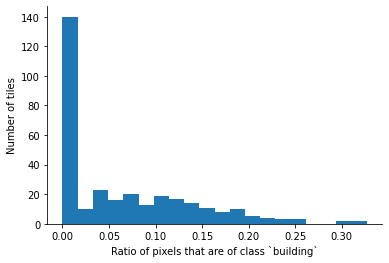

Mean Percentage of Pixels Belonging to Buildings: 0.064


In [ ]:
tile_type = '512_512_eroded' # other options: '512_512 stride augmented', '256_256 stride', '512_512 stride augmented test', '512_512 stride augmented train'
percentages = check_dataset_balance(tile_type)

## 4. Model Training

### 4.1. U-Net

Run this nex cell to train a U-Net model for 100 epochs. The model will be saved in `model_dir`. The resulting .pkl file can then be used in the BEAM tool. 

In [ ]:
tile_type = '512_with_erosion'
backbone = 'resnet18'
fit_type = 'one_cycle'
learning_rate = None
epochs = 100
architecture = 'U-Net'
loss_function = None
model_dir = f'{path}/models/experiment_results/{architecture}/{backbone}'
create_missing_folder(model_dir)

learn, dls = u_net_model_training(tile_type, backbone, fit_type, learning_rate, epochs, loss_function, architecture='U-Net', split=.2)

learn.export(f'{model_dir}/{architecture}_{timestamp()}_exported.pkl')

## Predictions
This section shows how to run inference to generate predictions and perform evaluation on a test set.

These functions work together to create a pipeline for generating predictions from aerial imagery and saving them as shapefiles of detected buildings. They do this by creating tiles from an image, saving predictions for each tile, merging the predictions into a single image, and creating a shapefile from the merged image. The `create_tiles` function cuts the input image into tiles of a specified size and saves them to disk. The `save_predictions` function loads the saved tiles, runs them through a pre-trained model, and saves the resulting predictions to disk. The `merge_tiles` function combines the predictions from all tiles into a single image. The `get_saved_predictions` function loads the saved predictions from disk and returns them as a NumPy array. Finally, the `create_shp_from_mask` function converts the merged image into a shapefile of detected settlements. The resulting shapefile can be used to visualize the detected buildings in the original image.

The `merge_tiles` function is used to combine the predictions from all tiles into a single image. It takes as input a NumPy array of shape `(n, nrows, ncols, c)` or `(n, nrows, ncols)` and the original height and width of the image. If the input array has a color channel, the function reshapes it into a 4D array and then combines the tiles into a single image. If the input array does not have a color channel, the function reshapes it into a 3D array and then combines the tiles into a single image. 

The `save_predictions` function loads the saved tiles, runs them through the loaded model, and saves the resulting predictions to disk. The `create_tiles` function cuts the input image into tiles of a specified size and saves them to disk. The `get_image_tiles` function returns a sorted list of the first `n` image tile filenames in a directory. The `get_saved_predictions` function loads the saved predictions from disk and returns them as a NumPy array. Finally, the `create_shp_from_mask` function converts the merged image into a shapefile of detected settlements. 

The `create_inferences` function calls these functions in sequence to perform the entire process of creating tiles, saving predictions, merging tiles, and creating a shapefile. It first creates tiles from the input image using `create_tiles`, then saves predictions for each tile using `save_predictions`. It then merges the predictions into a single image using `merge_tiles` and creates a shapefile from the merged image using `create_shp_from_mask`. The resulting shapefile can be used to visualize the detected settlements in the original image.

In [ ]:
input_names = []
tile_dir = f"{path}/image_tiles_inference" # set the path to the folder containing the tiles
inf_tile_size = 1000
predicted_dir =  f"{path}/saved_preds" # set the path to the folder where the predicted masks should be saved
file = f'{path}/your_file.tif' # set the path to the image that should be used for inference
image_shape_x = None
image_shape_y = None
loaded_model = load_learner(f"your_saved_model") # or set to learn if you want to use the model you just trained
output_folder = f"{model_dir}/predictions" # set the path to the folder where the predicted masks should be saved
create_missing_folder(output_folder)

In [ ]:
def create_tiles(image_path):
    """
    cuts the big image (from the path) into tiles with tile size as stated in the global variables. the images are
    squared.
    the tiles will be saved under /images_tiles/image_name/...png
    """
    tilling_start_time = datetime.now()
    global tile_dir, loaded_model
    global inf_tile_size
    global image_shape_x, image_shape_y
    if not exists(tile_dir):
        makedirs(tile_dir)
    # add condition to test the file size if it is 0 then just return?
    img = np.array(PILImage.create(image_path))
    image_shape_x, image_shape_y, _ = img.shape
    img_name = image_path.split("/")[-1]
    if exists(join(tile_dir, img_name)):
        filelist = glob.glob(join(tile_dir, img_name, img_name + "*.png"))
        for f in filelist:
            remove(f)
    else:
        makedirs(join(tile_dir, img_name))
    # Cut tiles and save them
    for i in range(image_shape_x // inf_tile_size):
        for j in range(image_shape_y // inf_tile_size):
            img_tile = img[
                       i * inf_tile_size: (i + 1) * inf_tile_size, j * inf_tile_size: (j + 1) * inf_tile_size
                       ]
            Image.fromarray(img_tile).save(
                f"{join(tile_dir, img_name)}/{img_name}_000{i * (image_shape_x // inf_tile_size) + j}.png"
            )
    tilling_end_time = datetime.now()


def get_image_tiles(nbr_tiles, img_name) -> L:
    """
    Helper function to return a sorted list of the first `n` image tile filenames in `path`

    """
    global tile_dir
    files = L()
    files.extend(get_image_files(path=tile_dir, folders=img_name)[:nbr_tiles])
    return files


def save_predictions(image_path):
    """
    Saves the intermediary detected images from all tiles. Predicts all tiles of one scene and saves them to disk.
    """
    global loaded_model
    if not exists(predicted_dir):
        makedirs(predicted_dir)
    img_name = image_path.split("/")[-1]
    # get all the tiles from the directory they belong to.
    tiles = os_sorted(get_image_tiles(len(listdir(join(tile_dir, img_name))), img_name))
    # predict all tiles and save them to disk
    for i in range(len(tiles)):
        pred, _, outputs = loaded_model.predict(tiles[i]) # predict the mask for the tile
        output = torch.exp(pred[:, :]).detach().cpu().numpy() # convert the mask to a numpy array
        np.save(f"{predicted_dir}/saved_{i:02d}", output) # save the mask
    outputs = os_sorted(glob.glob(f"{predicted_dir}/*.npy")) # get the filenames of the saved masks
    return len(tiles) == len(outputs) # return True if the number of tiles is equal to the number of saved masks


def merge_tiles(arr, h, w):
    """
    Takes as input a NumPy array of shape (n, nrows, ncols, c) or (n, nrows, ncols) 
    and the original height and width of the image. 
    If the array has a color channel, will reshape into a 3d array of shape HWC.
    If no color channel, will reshape into array of shape: h, w.
    NB: Currently only works without color channel (NHWC wrong shape for PyTorch tensors) 
    """

    try:  # with color channel
        n, nrows, ncols, c = arr.shape # get the shape of the array
        return (
            arr.reshape(h // nrows, -1, nrows, ncols, c).swapaxes(1, 2).reshape(h, w, c) # reshape the array
        )
    except ValueError:  # without color channel
        n, nrows, ncols = arr.shape # get the shape of the array
        return arr.reshape(h // nrows, -1, nrows, ncols).swapaxes(1, 2).reshape(h, w) # reshape the array


def get_saved_predictions():
    """
    Load saved prediction mask tiles for a scene and return assembled 
    mask based on the original image size by using the merge_tiles function.
    """
    mask_tiles = os_sorted(glob.glob(f"{predicted_dir}/*.npy")) # get the filenames of the saved masks
    mask_array = list(map(np.load, mask_tiles)) # load the saved masks
    global image_shape_x, image_shape_y, inf_tile_size 
    # Remove hard coded values
    if mask_array is None or len(mask_array) == 0:
        return None
    try: 
        mask_array = merge_tiles(
            np.array(mask_array),
            (image_shape_x // inf_tile_size) * inf_tile_size, 
            (image_shape_y // inf_tile_size) * inf_tile_size,
        )
    except ValueError as err:
        print(f"Unexpected {err=}, {type(err)=}")

    return mask_array


def create_shp_from_mask(file, mask_array):
    """
    Transforms the image to a geo-encoded image by
    Creates a shapefile from a binary mask array and saves it to disk. The shapefile contains polygons that represent 
    the connected regions of the mask. The function takes as input a file path to the original image and a binary mask 
    array of the same size as the original image. The function first dilates the mask with a 3x3 square kernel, which 
    is the inverse of the erosion applied in preprocessing. Then, it uses the `rasterio.features.shapes` function to 
    extract the shapes of the connected regions of the mask. Finally, it saves the shapes as polygons in a shapefile 
    with the same name as the original image file, suffixed with "_predicted.shp". If the mask array is None or has 
    length 1, the function creates an empty shapefile with the same name as the original image file, suffixed with 
    "_predicted.shp".
    """
    global output_folder
    if not os.path.exists(output_folder):
      os.makedirs(output_folder)
    with rasterio.open(file, "r") as src:
        raster_meta = src.meta
    # create an empty shapefile and interrupt the function.
    if mask_array is None or len(mask_array) == 1:
        pred_name = file.split("/")[-1]
        empty_schema = {"geometry": "Polygon", "properties": {"id": "int"}}
        no_crs = None
        gdf = gpd.GeoDataFrame(geometry=[])
        gdf.to_file(
            f"{output_folder}/{pred_name}_predicted.shp",
            driver="ESRI Shapefile",
            schema=empty_schema,
            crs=no_crs,
        )
        return
    mask_array = np.array(mask_array)
    # Dilate the mask with a 3x3 square kernel. This is the inverse of the erosion applied in preprocessing
    kernel = np.ones((3, 3), np.uint8)
    mask_array = cv2.dilate(mask_array, kernel, iterations=1)
    shapes = rasterio.features.shapes(mask_array, transform=raster_meta["transform"])
    polygons = [
        shapely.geometry.Polygon(shape[0]["coordinates"][0]) for shape in shapes
    ]
    my_list = raster_meta["crs"]
    gdf = gpd.GeoDataFrame(crs=my_list, geometry=polygons)
    gdf["area"] = gdf["geometry"].area
    gdf = gdf.drop([gdf["area"].idxmax()])
    # Drop shapes that are too small or too large to be a building
    gdf = gdf[(gdf["area"] > 2) & (gdf["area"] < 500000)]
    pred_name = file.split("/")[-1]
    # in case the geo-dataframe is empty which means no settlements are detected
    if gdf.empty:
        empty_schema = {"geometry": "Polygon", "properties": {"id": "int"}}
        no_crs = None
        gdf = gpd.GeoDataFrame(geometry=[])
        gdf.to_file(
            f"{output_folder}/{pred_name}_predicted.shp",
            driver="ESRI Shapefile",
            schema=empty_schema,
            crs=no_crs,
        )
    else:
        gdf.to_file(
            f"{output_folder}/{pred_name}_predicted.shp", driver="ESRI Shapefile"
        )

def create_inferences(file: str):
    """
    Creates the inferences for the given file and saves them in the output folder.
    This is the main function that should be called to start the inference process.
    Takes as input a file path to the original image.
    """
    headers = {"Access-Control-Allow-Origin": "*"}
    process_start = datetime.now()
    global image_shape_x, image_shape_y
    inf_start = datetime.now()
    if (os.stat(file).st_size == 0):
        pred_name = file.split("/")[-1]
        empty_schema = {"geometry": "Polygon", "properties": {"id": "int"}}
        no_crs = None
        gdf = gpd.GeoDataFrame(geometry=[])
        gdf.to_file(
            f"{output_folder}/{pred_name}_predicted.shp",
            driver="ESRI Shapefile",
            schema=empty_schema,
            crs=no_crs,
        )

        content = {"message": "An empty Shape file for the empty image is stored."}


    create_tiles(file)
    saved_pred = save_predictions(file)
    inf_finish = datetime.now()
    img_name = file.split("/")[-1]
    if not saved_pred:
        content = {
            "message": "The tiles and outputs have mismatched, please start the segmenting process again!"
        }
        shutil.rmtree(join(tile_dir, img_name))
        filelist = glob.glob(join(predicted_dir, "*.npy"))
        for f in filelist:
            os.remove(f)


    else:
        create_shp_from_mask(file, get_saved_predictions())
        content = {"message": "Output saved in the Output Folder."}

        shutil.rmtree(join(tile_dir, img_name))
        filelist = glob.glob(join(predicted_dir, "*.npy"))
        for f in filelist:
            os.remove(f)
        process_finish = datetime.now()


In [ ]:
create_inferences(file)